In [66]:
import numpy as np
import matplotlib.pylab as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import sys
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as pl
from mpmath import *
#import plotly.graph_objects as go
from typing import Tuple, Iterable
#from plotly.subplots import make_subplots
#import plotly.express as px
import pandas as pd
import scipy.special as sp_spec
from brian2 import *
from matplotlib.transforms import TransformedBbox
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from brian2 import *
prefs.codegen.target = "numpy"
from tqdm import tqdm
import seaborn as sns
sns.set_theme()
import scipy.special as sp_spec


In [54]:
# This is a helper function to make the zoom-in effect plot at the end
def mark_inset_user(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

red = '#734B3E'
green = '#668F80'
orange = '#E0CA3C'

In [17]:
gizi=0.04 
giz=0.01
Eiz=-65.
Eizi=-60.
Ee=0.0
Ei=-80.0
Qi=5.0
Qe=1.5
tauize=1
tauizi=1
tau_adap=1
a_adap=1
d_adap=15
b_adap=0
tause=5e-3
tausi=5e-3
Ke=8000*0.05
Ki=2000*0.05
ue=0
T=0.05 # 0.015


DT=0.1 # time step
defaultclock.dt = DT*ms
N1 = 2000 # number of inhibitory neurons
N2 = 8000 # number of excitatory neurons 
TotTime=4000 #Simulation duration (ms)
duration = TotTime*ms

In [25]:
# This generates a temporal input

AmpStim = 10.
TauP1 = 20.
TauP2 = 20.

plat = 10
def heaviside(x):
    return 0.5 * (1 + np.sign(x))
    
    
def input_rate(t, t1_exc, tau1_exc, tau2_exc, ampl_exc, plateau):
    # t1_exc=10. # time of the maximum of external stimulation
    # tau1_exc=20. # first time constant of perturbation = rising time
    # tau2_exc=50. # decaying time
    # ampl_exc=20. # amplitude of excitation
    inp = ampl_exc * (np.exp(-(t - t1_exc) ** 2 / (2. * tau1_exc ** 2)) * heaviside(-(t - t1_exc)) + \
        heaviside(-(t - (t1_exc+plateau))) * heaviside(t - (t1_exc))+ \
        np.exp(-(t - (t1_exc+plateau)) ** 2 / (2. * tau2_exc ** 2)) * heaviside(t - (t1_exc+plateau)))
    return inp
    
    
t2 = np.arange(0, TotTime, DT)
test_input = []

for ji in t2:
    test_input.append(6.+input_rate(ji, 2000., TauP1, TauP2, AmpStim, plat))

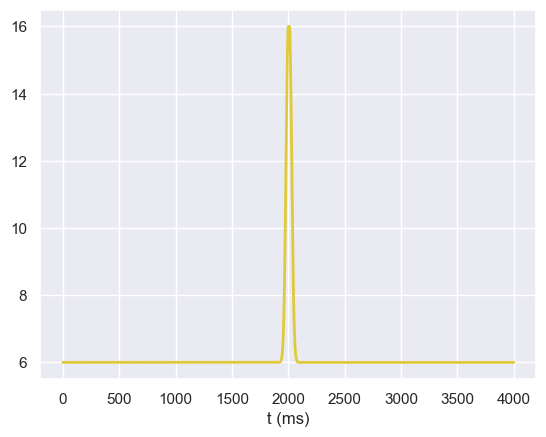

In [55]:
# Visualize the input
plt.figure()
plt.plot(t2, test_input, color=orange, linewidth = 2)
plt.xlabel('t (ms)')
plt.show()

In [27]:
def sv(ne,ni):
    muge=Qe*ne*tause*Ke
    mugi=Qi*ni*tause*Ki
    
    ui=0
    #ue=0
    ue=0.5*d_adap*ne*tau_adap/a_adap    #   du/dt=(a*(b*v-u)) + nu*d /Tu
   
    muve=((2*giz*Eiz+muge+mugi+b_adap)-np.sqrt((2*giz*Eiz+muge+mugi+b_adap)**2-4*giz*(giz*Eiz**2+muge*Ee+mugi*Ei-ue)))/(2*giz)
    muvi=((2*gizi*Eizi+muge+mugi)-np.sqrt((2*gizi*Eizi+muge+mugi)**2-4*gizi*(gizi*Eizi**2+muge*Ee+mugi*Ei-ui)))/(2*gizi)
   
    ae=giz*(muve-Eiz)**2
    ai=gizi*(muvi-Eizi)**2
 
    be=Qe*(Ee-muve)
    bi=Qi*(Ei-muvi)
    ce=tause
    ci=tausi
    
    sv=np.sqrt(Ke*ne*(2*ae*be*ce**3/tauize**2+ce**3*be**2/(8*tauize)+be**2*ce**3/(8*tauize**2)) + Ki*ni*(2*ai*bi*ci**3/tauizi**2+ci**3*bi**2/(8*tauizi)+bi**2*ci**3/(8*tauizi**2)))
    
    #print('sv=',sv)
    return sv
    
def tauv(ne,ni):
    
    ne=ne+1e-9
    ni=ni+1e-9
    muge=Qe*ne*tause*Ke
    mugi=Qi*ni*tause*Ki
    #mug=muge+mugi+giz
    ui=0
    #ue=0
    ue=0.5*d_adap*ne**tau_adap/a_adap
    muve=((2*giz*Eiz+muge+mugi+b_adap)-np.sqrt((2*giz*Eiz+muge+mugi+b_adap)**2-4*giz*(giz*Eiz**2+muge*Ee+mugi*Ei-ue)))/(2*giz)
    muvi=((2*gizi*Eizi+muge+mugi)-np.sqrt((2*gizi*Eizi+muge+mugi)**2-4*gizi*(gizi*Eizi**2+muge*Ee+mugi*Ei-ui)))/(2*gizi)

    
    ae=giz*(muve-Eiz)**2
    ai=gizi*(muvi-Eizi)**2
    be=Qe*(Ee-muve)
    bi=Qi*(Ei-muvi)
    ce=tause
    ci=tausi
    
    svv2=Ke*ne*(2*ae*be*ce**3/tauize**2+ce**3*be**2/(8*tauize)+be**2*ce**3/(8*tauize**2)) + Ki*ni*(2*ai*bi*ci**3/tauizi**2+ci**3*bi**2/(8*tauizi)+bi**2*ci**3/(8*tauizi**2))
    
    tauv=0.5*(Ke*ne*(be**2*ce**4/(2*np.pi*tauize**2))+Ki*ni*(bi**2*ci**4/(2*np.pi*tauizi**2)))/(svv2+1e-9)
    
    #print('tauv=',tauv)
    return tauv

In [28]:

def TF(nu,Po,Pmuv,Psv,Ptauv,Pvsv,Pvtauv,Psvtauv,Pvv,Ptt,Pss,giz,Eiz,d_ad):

    ne,ni=nu
    muge=Qe*ne*tause*Ke
    mugi=Qi*ni*tause*Ki
    mug=muge+mugi+giz
    ui=0

    ue=0.5*d_adap*ne*tau_adap/a_adap  #u_st=(b*nu+a*b*v)*tau/a#du/dt=(a*(b*v-u))/Tu
    
    muvo=-45
    dmuvo=2
    svo=4
    dsvo=5
    tauvo=0.005
    dtauvo=0.05
    
    muv=((2*giz*Eiz+muge+mugi+b_adap)-np.sqrt((2*giz*Eiz+muge+mugi+b_adap)**2-4*giz*(giz*Eiz**2+muge*Ee+mugi*Ei-ue)))/(2*giz)
    
    Pscale=1.
    noutf=Pscale*(sp_spec.erfc(((Po + Pmuv*(muv-muvo)/dmuvo + Psv*(sv(ne,ni)-svo)/dsvo + Ptauv*(tauv(ne,ni)-tauvo)/dtauvo \
            +Pvsv*(muv-muvo)*(sv(ne,ni)-svo)/(dsvo*dmuvo) + Pvtauv*(muv-muvo)*(tauv(ne,ni)-tauvo)/(dtauvo*dmuvo)\
            +Psvtauv*(sv(ne,ni)-svo)*(tauv(ne,ni)-tauvo)/(dtauvo*dsvo) + Pvv*(muv-muvo)**2/(dmuvo*dmuvo) \
            +Ptt*(tauv(ne,ni)-tauvo)**2/(dtauvo*dtauvo) + Pss*(sv(ne,ni)-svo)**2/(dsvo*dsvo))-muv)/(np.sqrt(2)*sv(ne,ni)) ))/(2*tauv(ne,ni))

        
    return noutf

In [29]:
def sv(ne,ni,ue):
    muge=Qe*ne*tause*Ke
    mugi=Qi*ni*tause*Ki

    ui=0
    #ue=0
    ue=ue
    muve=((2*giz*Eiz+muge+mugi+b_adap)-np.sqrt((2*giz*Eiz+muge+mugi+b_adap)**2-4*giz*(giz*Eiz**2+muge*Ee+mugi*Ei-ue)))/(2*giz)
    muvi=((2*gizi*Eizi+muge+mugi)-np.sqrt((2*gizi*Eizi+muge+mugi)**2-4*gizi*(gizi*Eizi**2+muge*Ee+mugi*Ei-ui)))/(2*gizi)


    ae=giz*(muve-Eiz)**2
    ai=gizi*(muvi-Eizi)**2
 
    be=Qe*(Ee-muve)#/mug  Note that we are not using mug!!!
    bi=Qi*(Ei-muvi)#/mug
    ce=tause
    ci=tausi
    
    argsv=Ke*ne*(2*ae*be*ce**3/tauize**2+ce**3*be**2/(8*tauize)+be**2*ce**3/(8*tauize**2)) + Ki*ni*(2*ai*bi*ci**3/tauizi**2+ci**3*bi**2/(8*tauizi)   +bi**2*ci**3/(8*tauizi**2))

    if argsv>0:
    	sv=np.sqrt(Ke*ne*(2*ae*be*ce**3/tauize**2+ce**3*be**2/(8*tauize)+be**2*ce**3/(8*tauize**2)) + Ki*ni*(2*ai*bi*ci**3/tauizi**2+ci**3*bi**2/(8*tauizi)+bi**2*ci**3/(8*tauizi**2)))

    else:
    	sv=1e-9
    
    #print('sv=',sv)
    return sv
    
def tauv(ne,ni,ue):
    
    ne=ne+1e-9
    ni=ni+1e-9
    muge=Qe*ne*tause*Ke
    mugi=Qi*ni*tause*Ki
    ui=0
    #ue=ue
    muve=((2*giz*Eiz+muge+mugi+b_adap)-np.sqrt((2*giz*Eiz+muge+mugi+b_adap)**2-4*giz*(giz*Eiz**2+muge*Ee+mugi*Ei-ue)))/(2*giz)
    muvi=((2*gizi*Eizi+muge+mugi)-np.sqrt((2*gizi*Eizi+muge+mugi)**2-4*gizi*(gizi*Eizi**2+muge*Ee+mugi*Ei-ui)))/(2*gizi)
    

    ae=giz*(muve-Eiz)**2
    ai=gizi*(muvi-Eizi)**2
    be=Qe*(Ee-muve)
    bi=Qi*(Ei-muvi)
    ce=tause
    ci=tausi
  
    
    argv=Ke*ne*(2*ae*be*ce**3/tauize**2+ce**3*be**2/(8*tauize)+be**2*ce**3/(8*tauize**2)) + Ki*ni*(2*ai*bi*ci**3/tauizi**2+ci**3*bi**2/(8*tauizi)+bi**2*ci**3/(8*tauizi**2))
    if argv >0:
    	svv2=Ke*ne*(2*ae*be*ce**3/tauize**2+ce**3*be**2/(8*tauize)+be**2*ce**3/(8*tauize**2)) + Ki*ni*(2*ai*bi*ci**3/tauizi**2+ci**3*bi**2/(8*tauizi)+bi**2*ci**3/(8*tauizi**2))
    
    	tauv=0.5*(Ke*ne*(be**2*ce**4/(2*np.pi*tauize**2))+Ki*ni*(bi**2*ci**4/(2*np.pi*tauizi**2)))/(svv2+1e-9)
        
    else:
      tauv=1
      #print('tauv=',tauv)
    return tauv



def TF(nu,P,ue,giz,Eiz):

    ne,ni=nu
    Po,Pmuv,Psv,Ptauv,Pvsv,Pvtauv,Psvtauv,Pvv,Ptt,Pss=P
    #ne=nu
    #ni=8
    muge=Qe*ne*tause*Ke
    mugi=Qi*ni*tause*Ki
    mug=muge+mugi+giz
    ui=0
    #ue=ue
    muvo=-45
    dmuvo=2
    svo=4
    dsvo=5
    tauvo=0.005
    dtauvo=0.05
    
    
    muv=((2*giz*Eiz+muge+mugi)-np.sqrt((2*giz*Eiz+muge+mugi+b_adap)**2-4*giz*(giz*Eiz**2+muge*Ee+mugi*Ei-ue)))/(2*giz)
    #muv=muve

 
    Pscale=1.
    noutf=Pscale*(sp_spec.erfc(((Po + Pmuv*(muv-muvo)/dmuvo + Psv*(sv(ne,ni,ue)-svo)/dsvo + Ptauv*(tauv(ne,ni,ue)-tauvo)/dtauvo \
            +Pvsv*(muv-muvo)*(sv(ne,ni,ue)-svo)/(dsvo*dmuvo) + Pvtauv*(muv-muvo)*(tauv(ne,ni,ue)-tauvo)/(dtauvo*dmuvo)\
            +Psvtauv*(sv(ne,ni,ue)-svo)*(tauv(ne,ni,ue)-tauvo)/(dtauvo*dsvo) + Pvv*(muv-muvo)**2/(dmuvo*dmuvo) \
            +Ptt*(tauv(ne,ni,ue)-tauvo)**2/(dtauvo*dtauvo) + Pss*(sv(ne,ni,ue)-svo)**2/(dsvo*dsvo))-muv)/(np.sqrt(2)*sv(ne,ni,ue)) ))/(2*tauv(ne,ni,ue))
 
        
    return noutf



def muv_func(ne,ni,ue):

    muge=Qe*ne*tause*Ke
    mugi=Qi*ni*tause*Ki

    ui=0
    #ue=0
    ue=ue
    muve=((2*giz*Eiz+muge+mugi+b_adap)-np.sqrt((2*giz*Eiz+muge+mugi+b_adap)**2-4*giz*(giz*Eiz**2+muge*Ee+mugi*Ei-ue)))/(2*giz)
    muvi=((2*gizi*Eizi+muge+mugi)-np.sqrt((2*gizi*Eizi+muge+mugi)**2-4*gizi*(gizi*Eizi**2+muge*Ee+mugi*Ei-ui)))/(2*gizi)

    return muve, muvi

f = open('RS_fit.txt', 'r')
lines = f.readlines()
PRS=np.zeros(10)

for i in range(0,len(PRS)):
    PRS[i]=lines[i]

f.close()


f = open('FS_fit.txt', 'r')
lines = f.readlines()
PFS=np.zeros(10)

for i in range(0,len(PRS)):
    PFS[i]=lines[i]

f.close()

#PRS=np.asarray(PRS)
#PFS=np.asarray(PFS)
#print PRS



tfinal=2.
dt=0.0001

t = np.linspace(0, tfinal, int(tfinal/dt))

f = open('time.txt', 'wb')

fecont=3;
ficont=7;
dRS=15
aRS=1
w=0.5*fecont*dRS/aRS


LSw=[]
LSfe=[]
LSfi=[]



for i in range(len(t)):
        
    fecontold=fecont
    fecont+=dt/T*(TF((fecont+test_input[i],ficont), PRS,w,giz,Eiz)-fecont) 
    w+=dt*( -aRS*w+(dRS)*fecontold)
    ficont+=dt/T*(TF((fecont+test_input[i],ficont),PFS,0,gizi,Eizi) - ficont) 
    LSfe.append(float(fecont))
    LSfi.append(float(ficont))
    LSw.append(float(w))
    

# plt.plot(t, LSfe)
# plt.plot(t, LSfi)
# fig=plt.figure()
# #plt.plot(LSfe, LSfi)
# ax = fig.add_subplot(1, 1, 1, projection = '3d')
# ax.plot(LSfe, LSfi, LSw)
# plt.figure()
# plt.plot(LSfe,LSfi)
# plt.figure()
# plt.plot(t, LSw)
# plt.show()

In [34]:
start_scope()

seed(42)

gizi=0.04 
giz=0.01
Eiz=-65.
Eizi=-60.
Ee=0.0
Ei=-80.0
Qi=5.0
Qe=1.5
tauize=1
tauizi=1
tau_adap=1
a_adap=1
d_adap=15
b_adap=0
tause=5e-3
tausi=5e-3
Ke=8000*0.05
Ki=2000*0.05
ue=0
T=0.05 # 0.015


DT=0.1 # time step
defaultclock.dt = DT*ms
N1 = 2000 # number of inhibitory neurons
N2 = 8000 # number of excitatory neurons 
TotTime=4000 #Simulation duration (ms)
duration = TotTime*ms

#(0.04*v**2+5*v+140-u-GsynE*(v-Ee)-GsynI*(v-Ei)-I)/Tn:1
eqs="""
dv/dt=(g_iz*(v-E_iz)**2-u-GsynE*(v-Ee)-GsynI*(v-Ei)-I)/Tv:1 (unless refractory)
du/dt=(a*(b*v-u))/Tu:1
dGsynI/dt = -GsynI/Tsyn : 1
dGsynE/dt = -GsynE/Tsyn : 1  
a:1
b:1
c:1
d:1
g_iz:1
E_iz:1
Tsyn:second
Tv:second
Tu:second
Ee:1
Ei:1
I:1
"""
#Pvar:1
#Qi:1
#Qe:1
#"""

# Population 1 - Fast Spiking

G_inh = NeuronGroup(N1, eqs, threshold='v > -30.', reset='v = c; u=u+d',refractory='5*ms', method='heun')

G_inh.v=-50
G_inh.u=0
G_inh.a=0.#0.1
G_inh.b=0.#0.2
G_inh.c=-55
G_inh.d=0.0
G_inh.Tsyn=5.*ms
G_inh.Tv=1*second
G_inh.Tu=1*second
G_inh.Ee=0.0
G_inh.Ei=-80.
G_inh.I=0.
G_inh.g_iz=0.04
G_inh.E_iz=-60


# Population 2 - Regular Spiking
G_exc = NeuronGroup(N2, eqs, threshold='v > -30.', reset='v = c; u=u+d',refractory='5*ms', method='heun')
G_exc.v=-50
G_exc.u=0#25
G_exc.a=1
G_exc.b=0.0#0.2
G_exc.c=-65
G_exc.d=15.0#8.0
G_exc.Tsyn=5.*ms
G_exc.Tv=1*second
G_exc.Tu=1*second
G_exc.Ee=0.0
G_exc.Ei=-80.
G_exc.I=0.0
G_exc.g_iz=0.01
G_exc.E_iz=-65

# external drive--------------------------------------------------------------------------

# The following lines include such input into the brian network simulation
Input_Stim=TimedArray(test_input*Hz, dt=DT*ms)
P_ed=PoissonGroup(8000, rates='Input_Stim(t)')
# stimulus = TimedArray(np.tile([5.0, 0.], int(TotTime/DT/2))*Hz, dt=DT*ms)
# P_ed=PoissonGroup(N2, rates= 'stimulus(t)') #input_hz*Hz)

# Network-----------------------------------------------------------------------------

# connections-----------------------------------------------------------------------------
#seed(0)

prbC=.05 #0.05
 
S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV')
S_12.connect('i!=j', p=prbC)

S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post+=Qi')
S_11.connect('i!=j',p=prbC)

S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post+=Qe')
S_21.connect('i!=j',p=prbC)

S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post+=Qe')
S_22.connect('i!=j', p=prbC)

S_ed_in = Synapses(P_ed, G_inh, on_pre='GsynE_post+=Qe')
S_ed_in.connect(p=prbC)

S_ed_ex = Synapses(P_ed, G_exc, on_pre='GsynE_post+=Qe')
S_ed_ex.connect(p=prbC)


PgroupE = NeuronGroup(1, 'P:1', method='heun')
		
PE=Synapses(G_exc, PgroupE, 'P_post = u_pre : 1 (summed)')
PE.connect(p=1)
P2mon = StateMonitor(PgroupE, 'P', record=0)


PgroupMuVE = NeuronGroup(1, 'Pv:1', method='heun')
		
PmuE=Synapses(G_exc, PgroupMuVE, 'Pv_post = v_pre : 1 (summed)')
PmuE.connect(p=1)
P2MuVemon = StateMonitor(PgroupMuVE, 'Pv', record=0)


# Recording tools -------------------------------------------------------------------------------
rec1=1
rec2=2

M1G_inh = SpikeMonitor(G_inh)
FRG_inh = PopulationRateMonitor(G_inh)
M1G_exc = SpikeMonitor(G_exc)
FRG_exc = PopulationRateMonitor(G_exc)

M2G1 = StateMonitor(G_inh, 'v', record=range(rec1))
M3G1 = StateMonitor(G_inh, 'u', record=range(rec1))
M4G1 = StateMonitor(G_inh, 'GsynE', record=range(rec1))
M5G1 = StateMonitor(G_inh, 'GsynI', record=range(rec1))

M2G2 = StateMonitor(G_inh, 'v', record=range(rec2))
M3G2 = StateMonitor(G_inh, 'u', record=range(rec2))
M4G2 = StateMonitor(G_inh, 'GsynE', record=range(rec2))
M5G2 = StateMonitor(G_inh, 'GsynI', record=range(rec2))

# Run simulation -------------------------------------------------------------------------------

print('--##Start simulation##--')
run(duration)
print('--##End simulation##--')


# Plots -------------------------------------------------------------------------------

Lt1G1=array(M2G1.t/ms)
Lt2G1=array(M3G1.t/ms)
Lt1G2=array(M2G2.t/ms)
Lt2G2=array(M3G2.t/ms)
LVG1=[]
LwG1=[]
LVG2=[]
LwG2=[]

LgseG1=[]
LgsiG1=[]
LgseG2=[]
LgsiG2=[]

for a in range(rec1):
    LVG1.append(array(M2G1[a].v))
    LwG1.append(array(M3G1[a].u))
    LgseG1.append(array(M4G1[a].GsynE/nS))
    LgsiG1.append(array(M5G1[a].GsynI/nS))

for a in range(rec2):
    LVG2.append(array(M2G2[a].v))
    LwG2.append(array(M3G2[a].u))
    LgseG2.append(array(M4G2[a].GsynE/nS))
    LgsiG2.append(array(M5G2[a].GsynI/nS))

#create the figure
# fig=plt.figure(figsize=(12,8))
# ax1=fig.add_subplot(221)
# ax2=fig.add_subplot(222)
# ax3=fig.add_subplot(223)
# ax4=fig.add_subplot(224)

# for a in range(len(LVG1)):
#     ax1.plot(Lt1G1, LVG1[a], color ='r')
#     ax1.plot(Lt1G1, LVG1[a], ls=(0, (2,6))) 
#     ax3.plot(Lt2G1, LwG1[a],color ='r')
#     ax3.plot(Lt2G1, LwG1[a],ls=(0, (2,6))) 


# for a in range(len(LgseG1)):
#     ax2.plot(Lt1G1, LgsiG1[a], color ='r')
#     ax2.plot(Lt1G1, LgsiG1[a], ls=(0, (2,6))) 
#     ax2.plot(Lt1G1, LgseG1[a], color ='g')
#     ax2.plot(Lt1G1, LgseG1[a], ls=(0, (2,6))) 

# for a in range(len(LVG2)):
#     ax1.plot(Lt1G2, LVG2[a],color ='g')
#     ax1.plot(Lt1G2, LVG2[a], ls=(0, (2,6))) 
#     ax3.plot(Lt2G2, LwG2[a],color ='g')
#     ax3.plot(Lt2G2, LwG2[a], ls=(0, (2,6)))

# for a in range(len(LgsiG2)):
#     ax4.plot(Lt1G1, LgsiG2[a], color ='r')
#     ax4.plot(Lt1G1, LgsiG2[a], ls=(0, (2,6))) 
#     ax4.plot(Lt1G1, LgseG2[a], color ='g')
#     ax4.plot(Lt1G1, LgseG2[a], ls=(0, (2,6))) 


WARNING    'j' is an internal variable of group 'synapses_6', but also exists in the run namespace with the value mpc(real='0.0', imag='1.0'). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_6', but also exists in the run namespace with the value 19999. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Ee' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 0.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Ei' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value -80.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'a' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 1. 

--##Start simulation##--
--##End simulation##--


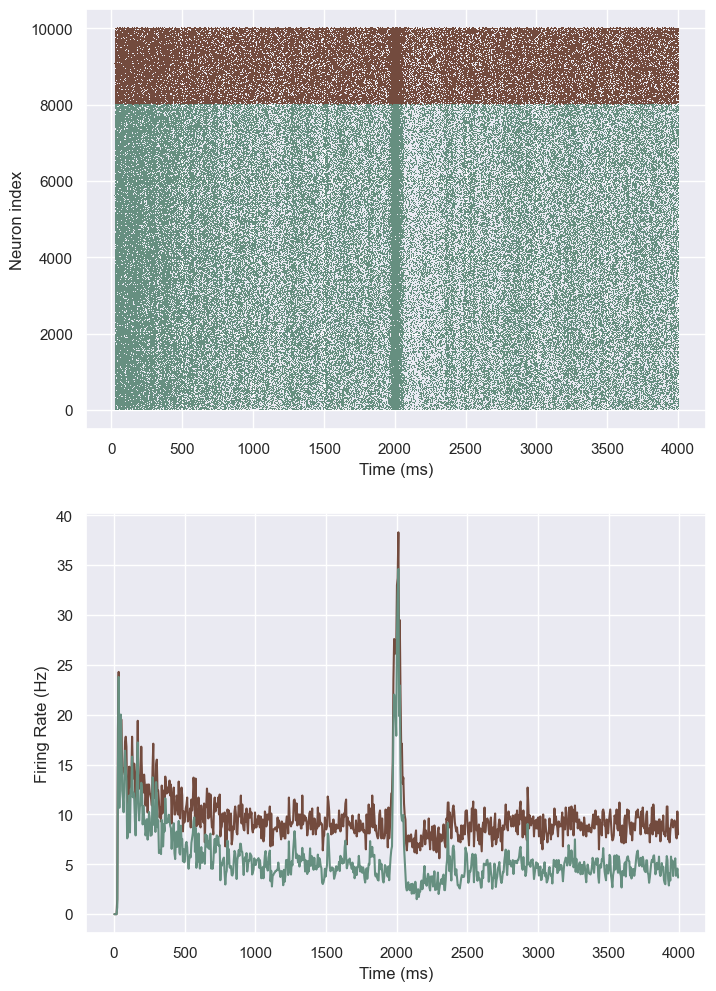

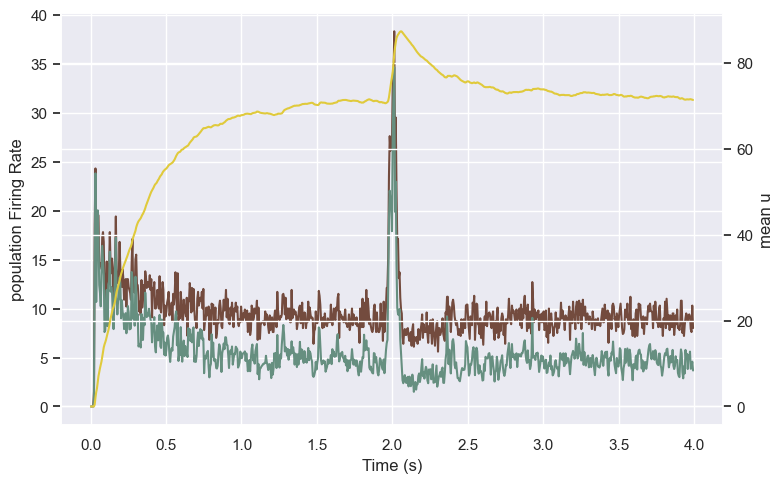

In [56]:
# create the figure

# prepare raster plot
RasG_inh = array([M1G_inh.t/ms, [i+N2 for i in M1G_inh.i]])
RasG_exc = array([M1G_exc.t/ms, M1G_exc.i])



# prepare firing rate
def bin_array(array, BIN, time_array):
    N0 = int(BIN/(time_array[1]-time_array[0]))
    N1 = int((time_array[-1]-time_array[0])/BIN)
    return array[:N0*N1].reshape((N1,N0)).mean(axis=1)

BIN=5
time_array = arange(int(TotTime/DT))*DT



LfrG_exc=array(FRG_exc.rate/Hz)
TimBinned,popRateG_exc=bin_array(time_array, BIN, time_array),bin_array(LfrG_exc, BIN, time_array)

LfrG_inh=array(FRG_inh.rate/Hz)
TimBinned,popRateG_inh=bin_array(time_array, BIN, time_array),bin_array(LfrG_inh, BIN, time_array)

fig=figure(figsize=(8,12))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)


ax1.plot(RasG_inh[0], RasG_inh[1], ',', color=red)
ax1.plot(RasG_exc[0], RasG_exc[1], ',', color=green)

ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Neuron index')

ax2.plot(TimBinned,popRateG_inh, color=red)
ax2.plot(TimBinned,popRateG_exc, color=green)

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Firing Rate (Hz)')

TimBinned,Pu=bin_array(time_array, BIN, time_array),bin_array(P2mon[0].P, BIN, time_array)
fig=plt.figure(figsize=(8,5))
ax3=fig.add_subplot(111)
ax2 = ax3.twinx()
ax3.plot(TimBinned/1000,popRateG_inh, color=red)
ax3.plot(TimBinned/1000,popRateG_exc, color=green)
ax2.plot(TimBinned/1000,(Pu/8000), color=orange)
ax2.set_ylabel('mean u')
#ax2.set_ylim(0.0, 0.045)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('population Firing Rate')


# TimBinned,Pv=bin_array(time_array, BIN, time_array),bin_array(P2MuVemon[0].Pv, BIN, time_array)
# fig=plt.figure(figsize=(12,5))
# plt.plot(TimBinned/1000,(Pv/8000), 'blue')
#ax1=fig.add_subplot(211)
#ax2=fig.add_subplot(212)
#ax1.set_title('P neuron group')
#ax1.plot(P1mon.P[0])
#ax1.plot(P2mon.P[0])
#ax2.set_title('P received by the neuron')
#ax2.plot(G1mon.Pvar[0])
#ax2.plot(G2mon.Pvar[0])

fig.tight_layout()

show()

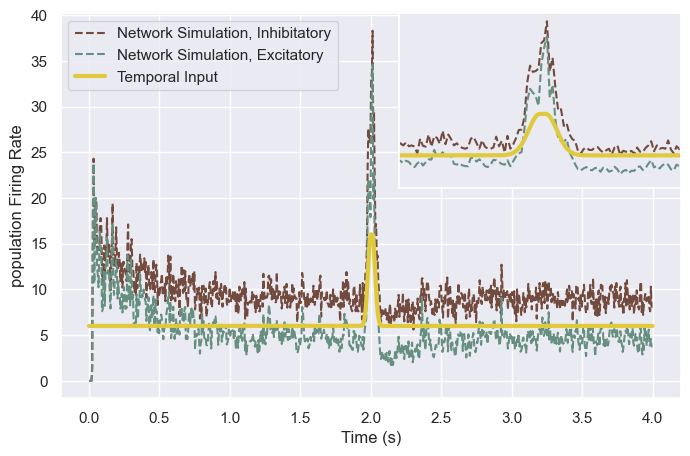

In [93]:
# change this for slower input
left_lim = 1.75
right_lim = 2.25
###############################

TimBinned,Pu=bin_array(time_array, BIN, time_array),bin_array(P2mon[0].P, BIN, time_array)

fig=plt.figure(figsize=(8,5))

ax3=fig.add_subplot(111)
ax3.plot(TimBinned/1000,popRateG_inh, '--', color=red, label='Network Simulation, Inhibitatory')
ax3.plot(TimBinned/1000,popRateG_exc, '--', color=green, label='Network Simulation, Excitatory')
ax3.plot(t2/1000, test_input, color=orange, linewidth = 3, label='Temporal Input')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('population Firing Rate')

axin3=fig.add_subplot(222)
axin3.plot(TimBinned/1000,popRateG_inh, '--', color=red)
axin3.plot(TimBinned/1000,popRateG_exc, '--', color=green)
axin3.plot(t2/1000, test_input, color=orange, linewidth = 3)
axin3.set_xlim((left_lim, right_lim))
axin3.get_xaxis().set_visible(False)
axin3.get_yaxis().set_visible(False)

ax3.legend(loc='upper left')
plt.show()